In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn tensorflow gensim



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from gensim.models import Word2Vec


In [7]:
import sys
import os

# Add the project root (one level above 'notebook/') to sys.path
sys.path.append(os.path.abspath(".."))

from src import preprocessing


In [9]:
train_df = pd.read_csv("../results/train.csv")
test_df = pd.read_csv("../results/test.csv")

# Quick preview
train_df.head()


,clean_text,label_id,category_name
0,43inch tv led backlight strip bn96 37294a 3729...,58,Televisions
1,tweezerman mini slant tweezer green tea,52,Shaving Hair Removal Products
2,electric nose hair trimmer ear and nose hair t...,52,Shaving Hair Removal Products
3,women s high top sneaker comfortable casual la...,62,Women's Shoes
4,mtssii cat eye gel nail polish moonstone cat e...,7,Beauty


Prepare the text for LSTM

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCAB_SIZE = 50000
MAX_SEQUENCE_LENGTH = 30  # adjust based on your text length analysis

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["clean_text"])

X_train = tokenizer.texts_to_sequences(train_df["clean_text"])
X_test = tokenizer.texts_to_sequences(test_df["clean_text"])

X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding="post")

y_train = train_df["label_id"].values
y_test = test_df["label_id"].values


In [11]:
# ------------------------------
# Parameters
# ------------------------------
MAX_VOCAB = 50000      # top 50k words in vocabulary
MAX_LEN = 50           # max words per title
EMBEDDING_DIM = 100    # embedding vector size
NUM_CLASSES = 63       # number of unique labels


Tokenisation and Padding

In [12]:
# Tokenize text
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["clean_text"])

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df["clean_text"])
X_test_seq  = tokenizer.texts_to_sequences(test_df["clean_text"])

# Pad sequences to same length
X_train = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_test  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding="post", truncating="post")

# Targets
y_train = train_df["label_id"].values
y_test  = test_df["label_id"].values


Build LSTM Model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dense(NUM_CLASSES, activation="softmax")
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Compile Model

In [34]:
model.compile(
    loss="sparse_categorical_crossentropy",  # y are integer labels
    optimizer="adam",
    metrics=["accuracy"]
)


Train Model

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=256,
    callbacks=[early_stop]
)


Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.5496 - loss: 1.7616 - val_accuracy: 0.8562 - val_loss: 0.5185
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.8717 - loss: 0.4551 - val_accuracy: 0.8702 - val_loss: 0.4595
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.8945 - loss: 0.3577 - val_accuracy: 0.8723 - val_loss: 0.4592
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.9071 - loss: 0.3027 - val_accuracy: 0.8759 - val_loss: 0.4624
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.9165 - loss: 0.2662 - val_accuracy: 0.8742 - val_loss: 0.4741
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.9232 - loss: 0.2394 - val_accuracy: 0.8715 - val_loss: 0.5040


Evaluate Model

In [37]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.8732 - loss: 0.4542
Test Accuracy: 0.8726


TF-IDF and neural network

In [13]:
# Make sure text is string and a pandas Series
X_train = train_df["clean_text"].astype(str)
X_test = test_df["clean_text"].astype(str)

# Labels
y_train = train_df["label_id"]
y_test = test_df["label_id"]

print(type(X_train))
print(X_train.head())


<class 'pandas.Series'>
0    43inch tv led backlight strip bn96 37294a 3729...
1              tweezerman mini slant tweezer green tea
2    electric nose hair trimmer ear and nose hair t...
3    women s high top sneaker comfortable casual la...
4    mtssii cat eye gel nail polish moonstone cat e...
Name: clean_text, dtype: str


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=20000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(X_train_tfidf.shape)


(399997, 20000)


In [15]:
model_tfidf = Sequential([
    Dense(256, activation="relu", input_shape=(20000,)),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dense(63, activation="softmax")
])

model_tfidf.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model_tfidf.summary()


c:\Users\USER\Product-text-Classiifcation\myenv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     5,120,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 63)             │         8,127 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,161,279 (19.69 MB)

 Trainable params: 5,161,279 (19.69 MB)

 Non-trainable params: 0 (0.00 B)

Training TF-IDF model

In [16]:
history_tfidf = model_tfidf.fit(
    X_train_tfidf.toarray(),
    y_train,
    epochs=10,
    batch_size=256,
    validation_split=0.1
)


MemoryError: Unable to allocate 59.6 GiB for an array with shape (399997, 20000) and data type float64

Model 2: Skip-Gram and LSTM

In [17]:
tokenized_train = [text.split() for text in X_train]


Training Skip-gram Word 2vec

In [18]:
from gensim.models import Word2Vec

w2v_skip = Word2Vec(
sentences=tokenized_train,
vector_size=100,
window=5,
min_count=2,
sg=1  # Skip-gram
)


Tokenizer and sequence

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 20000
MAX_LEN = 40

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)


Building embedding matrix

In [24]:
import numpy as np

embedding_dim = 100
embedding_matrix = np.zeros((MAX_WORDS, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i >= MAX_WORDS:
        continue
    if word in w2v_skip.wv:
        embedding_matrix[i] = w2v_skip.wv[word]


Skip Gram LSTM model

In [25]:
from tensorflow.keras.layers import Embedding, LSTM

model_skip = Sequential([
    Embedding(
        MAX_WORDS,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False
    ),
    LSTM(128),
    Dense(63, activation="softmax")
])

model_skip.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model_skip.summary()


c:\Users\USER\Product-text-Classiifcation\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

Training the LSTM Model

In [26]:
history_skip = model_skip.fit(
    X_train_pad,
    y_train,
    epochs=8,
    batch_size=256,
    validation_data=(X_test_pad, y_test)
)


Epoch 1/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 270s 172ms/step - accuracy: 0.7901 - loss: 0.7595 - val_accuracy: 0.8374 - val_loss: 0.5539
Epoch 2/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 277s 177ms/step - accuracy: 0.8490 - loss: 0.5051 - val_accuracy: 0.8530 - val_loss: 0.4880
Epoch 3/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 280s 179ms/step - accuracy: 0.8620 - loss: 0.4551 - val_accuracy: 0.8602 - val_loss: 0.4621
Epoch 4/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 277s 177ms/step - accuracy: 0.8701 - loss: 0.4244 - val_accuracy: 0.8658 - val_loss: 0.4415
Epoch 5/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 278s 178ms/step - accuracy: 0.8756 - loss: 0.4010 - val_accuracy: 0.8671 - val_loss: 0.4342
Epoch 6/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 279s 179ms/step - accuracy: 0.8808 - loss: 0.3821 - val_accuracy: 0.8701 - val_loss: 0.4227
Epoch 7/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 281s 180ms/step - accuracy: 0.8848 - loss: 0.3668 - val_accuracy: 0.8708 - val_loss: 0.4164
Epoch 8/8
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 294s 188ms/step - accuracy: 

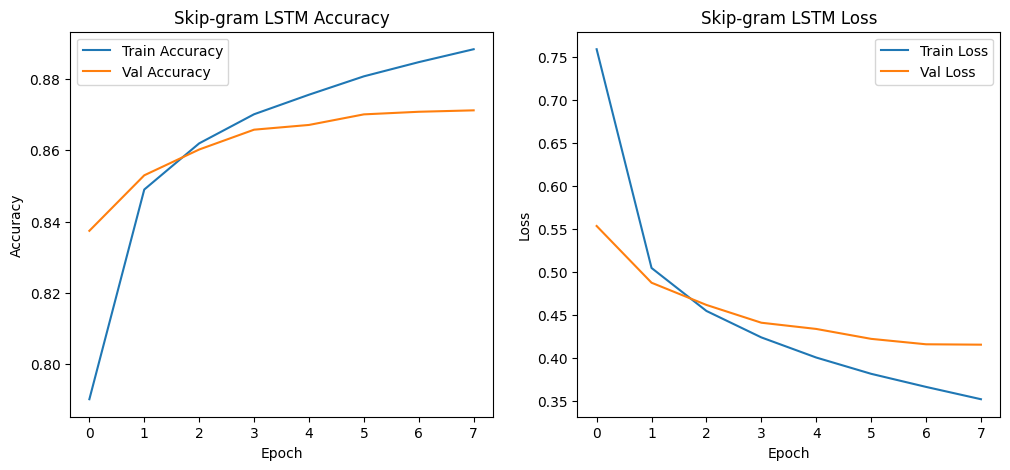

In [32]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_skip.history['accuracy'], label='Train Accuracy')
plt.plot(history_skip.history['val_accuracy'], label='Val Accuracy')
plt.title('Skip-gram LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(history_skip.history['loss'], label='Train Loss')
plt.plot(history_skip.history['val_loss'], label='Val Loss')
plt.title('Skip-gram LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [33]:
# Evaluate Skip-gram model on test set
test_loss_skip, test_acc_skip = model_skip.evaluate(X_test_pad, y_test)

print("Skip-gram Test Loss:", test_loss_skip)
print("Skip-gram Test Accuracy:", test_acc_skip)


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - accuracy: 0.8712 - loss: 0.4159
Skip-gram Test Loss: 0.4159345030784607
Skip-gram Test Accuracy: 0.8712300062179565


CBOW and LSTM

Training CBOW Word2Vec

In [27]:
w2v_cbow = Word2Vec(
    sentences=tokenized_train,
    vector_size=100,
    window=5,
    min_count=2,
    sg=0,  # CBOW
    workers=4
)


CBow embedding matrix

In [28]:
embedding_matrix_cbow = np.zeros((MAX_WORDS, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i >= MAX_WORDS:
        continue
    if word in w2v_cbow.wv:
        embedding_matrix_cbow[i] = w2v_cbow.wv[word]


CBOW LSTM Model

In [29]:
model_cbow = Sequential([
    Embedding(
        MAX_WORDS,
        embedding_dim,
        weights=[embedding_matrix_cbow],
        input_length=MAX_LEN,
        trainable=False
    ),
    LSTM(128),
    Dense(63, activation="softmax")
])

model_cbow.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)


Training CBOW Model

In [30]:
history_cbow = model_cbow.fit(
    X_train_pad,
    y_train,
    epochs=20,
    batch_size=256,
    validation_data=(X_test_pad, y_test)
)


Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 239s 151ms/step - accuracy: 0.8063 - loss: 0.7036 - val_accuracy: 0.8450 - val_loss: 0.5248
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 236s 151ms/step - accuracy: 0.8558 - loss: 0.4836 - val_accuracy: 0.8554 - val_loss: 0.4813
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 231s 148ms/step - accuracy: 0.8671 - loss: 0.4369 - val_accuracy: 0.8610 - val_loss: 0.4580
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 225s 144ms/step - accuracy: 0.8749 - loss: 0.4056 - val_accuracy: 0.8625 - val_loss: 0.4528
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 225s 144ms/step - accuracy: 0.8811 - loss: 0.3822 - val_accuracy: 0.8663 - val_loss: 0.4408
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 225s 144ms/step - accuracy: 0.8861 - loss: 0.3628 - val_accuracy: 0.8651 - val_loss: 0.4405
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 226s 145ms/step - accuracy: 0.8903 - loss: 0.3469 - val_accuracy: 0.8692 - val_loss: 0.4361
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 225s 144ms/step - ac

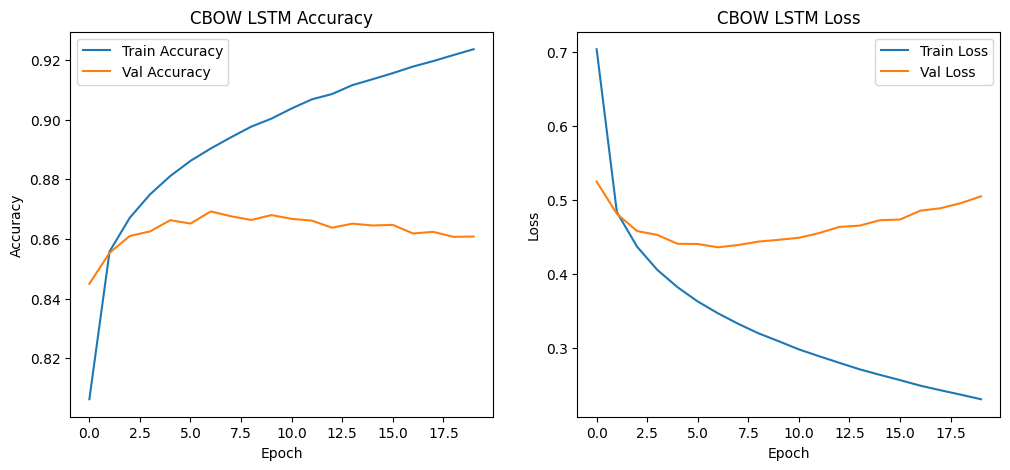

In [31]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_cbow.history['accuracy'], label='Train Accuracy')
plt.plot(history_cbow.history['val_accuracy'], label='Val Accuracy')
plt.title('CBOW LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(history_cbow.history['loss'], label='Train Loss')
plt.plot(history_cbow.history['val_loss'], label='Val Loss')
plt.title('CBOW LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [34]:
test_loss_cbow, test_acc_cbow = model_cbow.evaluate(X_test_pad, y_test)

print("CBOW Test Accuracy:", test_acc_cbow)


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - accuracy: 0.8608 - loss: 0.5049
CBOW Test Accuracy: 0.8607900142669678


In [36]:
print("Skip-gram Test Accuracy:", test_acc_skip)
print("Skip-gram Test Loss:", test_loss_skip)

print("CBOW Test Accuracy:", test_acc_cbow)
print("CBOW Test Loss:", test_loss_cbow)


Skip-gram Test Accuracy: 0.8712300062179565
Skip-gram Test Loss: 0.4159345030784607
CBOW Test Accuracy: 0.8607900142669678
CBOW Test Loss: 0.5048534870147705


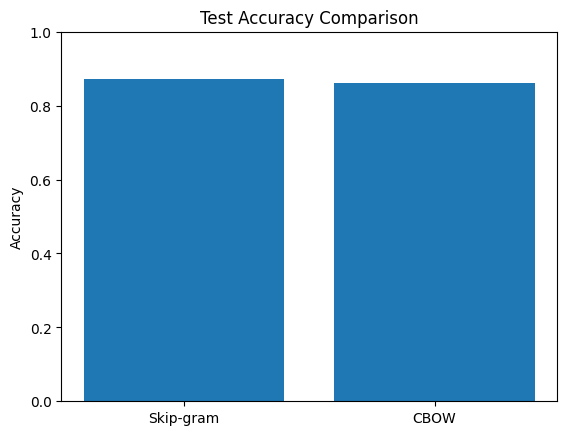

In [37]:
import matplotlib.pyplot as plt

models = ["Skip-gram", "CBOW"]
accuracies = [test_acc_skip, test_acc_cbow]

plt.figure()
plt.bar(models, accuracies)
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()
